In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

from keras.models import Model
from keras.layers import Bidirectional, Dense, Input, Dropout, LSTM, Activation, TimeDistributed, BatchNormalization, concatenate, Concatenate
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.initializers import glorot_uniform
from sklearn.model_selection import train_test_split

from itertools import chain

from grail_data_utils import *

%matplotlib inline

np.random.seed(1)'

Using TensorFlow backend.


In [2]:
# entire corpus
X, Y1, Y2, Z, vocabulary, vnorm, partsofspeech1, partsofspeech2, superset, maxLen = read_maxentdata('m2.txt')

In [3]:
numClasses = len(partsofspeech2)+1
numSuperClasses = len(superset)+1

print()
print("Longest sentence      : ", maxLen)
print("Number of words       : ", len(vocabulary))
print("Number of norm. words : ", len(vnorm))
print("Number of POS tags    : ", numClasses)
print("Number of supertags   : ", numSuperClasses)



Longest sentence      :  266
Number of words       :  30300
Number of norm. words :  28223
Number of POS tags    :  32
Number of supertags   :  891


In [4]:
# split the training data into the standard 60% train, 20% dev, 20% test 
X_train, X_testdev, Y_train, Y_testdev = train_test_split(X, Y2, test_size=0.4)
X_test, X_dev, Y_test, Y_dev = train_test_split(X_testdev, Y_testdev, test_size=0.5)
print("Train: ", X_train.shape)
print("Test:  ", X_test.shape)
print("Dev:   ", X_dev.shape)


Train:  (9449,)
Test:   (3150,)
Dev:    (3150,)


In [145]:

def get_features(string, cat):
    fset = set()

    if (cat == "v"):
        m0 = re.search(r"<(.*)>", string)
        if m0 is not None:
            for item in m0.group(1).split(','):
                fset.add(item)

    m1 = re.search(r"cat=(.*?)[,\]]", string)
    if m1 is not None:
        fset.add(m1.group(1))

    for m2 in re.findall(r"@(.*?)[,\]]", string):
        if not (m2 == "e"):
            fset.add(m2)
    return fset
  

In [173]:
possessive_features = set(['p_P1s', 'p_P2s', 'p_P3s', 'p_P1p', 'p_P2p', 'p_P3p',\
                           'fs_P1s', 'fs_P2s', 'fs_P3s',\
                           's_P1s', 's_P2s', 's_P3s', 's_P1p', 's_P2p', 's_P3p'])

verb_inflection_features = set(['P1s', 'P12s', 'P2s', 'P3s', 'P1p', 'P2p', 'P3p',\
                                'J1s', 'J12s', 'J2s', 'J3s', 'J1p', 'J2p', 'J3p',\
                                'T1s', 'T2s', 'T3s', 'T1p', 'T2p', 'T3p',\
                                'F1s', 'F2s', 'F3s', 'F1p', 'F2p', 'F3p',\
                                'C1s', 'C12s', 'C3s', 'C1p', 'C2p', 'C3p',\
                                'S1s', 'S13s', 'S2s', 'S3s', 'S1p', 'S2p', 'S3p',\
                                'Y2s', 'Y1p','Y2p', 'G', 'W',\
                                'I1s', 'I12s', 'I3s', 'I1p', 'I2p', 'I3p',\
                                'PS13s', 'PS3','PS2s', 'PS3p',\
                                'PJ12s', 'ST2s',\
                                'K', 'Km', 'Kms', 'Kfs', 'Kmp', 'Kfp'])

inflection_features = set(['ms', 'mp', 'fs', 'fp', '1s', '2s', '3s', '1p', '2p', '3p', '3fs', '3mp', '3fp'])

object_map  = { 'Obj:(cla|sn)':'sn', 'Obj:cla|qcompl|scompl|sinf|sn':'qcompl|scompl|sinf|sn',\
             'Obj:cla|scompl|sn':'scompl|sn', 'Obj:cla|de-sinf|sn':'de-sinf|sn',\
             'Obj:sinf':'sinf', 'Obj:(cla|scompl|sn)':'scompl|sn',\
             'Obj:(cla|scompl|sinf|sn)':'scompl|sinf|sn', 'Obj:(cla|seréc|seréfl|sn)':'sn',\
             'Obj:(à-sinf)':'à-sinf', 'Obj:cla|qcompl|scompl|sn':'qcompl|scompl|sn',\
             'Obj:(scompl|sinf)':'scompl|sinf', 'Obj:(cla|pour-sn|sn)':'pour-sn|sn',\
             'Obj:(cla|de-sinf|scompl|sn)':'de-sinf|scompl|sn', 'Obj:cla|scompl|sinf|sn':'scompl|sinf|sn',\
             'Obj:à-sinf':'à-sinf', 'Obj:(cla|de-sinf|sn|à-sinf)':'de-sinf|sn|à-sinf',\
             'Obj:(cla|qcompl|scompl|sn)':'qcompl|scompl|sn', 'Obj:(cla|de-sinf|sn)':'de-sinf|sn',\
             'Obj:de-sinf':'de-sinf', 'Obj:(cla|qcompl|scompl|sn|à-sinf)':'qcompl|scompl|sn|à-sinf',\
             'Obj:(cla|qcompl|scompl|sinf|sn)':'qcompl|scompl|sinf|sn', 'Obj:cla|sn':'sn',\
             'Obj:(cla|de-sinf|qcompl|scompl|sn)':'de-sinf|qcompl|scompl|sn',\
             'Obj:sn':'sn', 'Obj:scompl':'scompl', 'Obj:qcompl':'qcompl', 'Obj:pour-sn':'pour-sn'}


In [238]:
def transform_features(valset):
    features = set()
    for val in valset:
        if val in possessive_features:
            features.add("possessive")
        elif val in verb_inflection_features:
            fts = list(val)
            features = features.union(fts)
        elif val in inflection_features:
            fts = list(val)
            features = features.union(fts)
        elif val == "Obl:en-sn":
            features.add("Obl:(en-sn)")
        elif val == "Att:pour-sa|pour-sn":
            features.add("Att:(pour-sa|pour-sn)")
        elif val.startswith("Suj:"):
            None
        elif val.startswith("Objà:"):
            features.add("Objà")
        elif val.startswith("Objde:"):
            features.add("Objde")
        elif val.startswith("Obj:"):
            tmp = object_map[val]
            lst = tmp.split('|')
            for l in lst:
                features.add("Obj:" + l)
        else:
            features.add(val)
            
    return features

In [239]:

def read_lefff(file):
    vocabulary = set()
    tags = set()
    word_pos_map = {}
    max_word_len = 0
    with open(file, 'r') as f:
        for line in f:
            line = line.strip().split("\t")
            w = line[0]
            w = w.replace("æ", "ae")
            w = w.replace("œ", "oe")
            w = w.replace("-_", "-")
            word_len = len(w)
            if (word_len > max_word_len):
                max_word_len = word_len
            wlist = w.split()
            if (len(wlist) == 2):
                w = wlist[0]
                nextfeat == None
                if (wlist[1]).startswith("qu'"):
                    nextfeat = "Next:que"
                if (wlist[1]).startswith("que "):
                    nextfeat = "Next:que"
                if (wlist[1] == 'que'):
                    nextfeat = "Next:que"
                if (wlist[1]).startswith("d'"):
                    nextfeat = "Next:de"
                if (wlist[1]).startswith("de "):
                    nextfeat = "Next:de"
                if (wlist[1] == 'de'):
                    nextfeat = "Next:de"
                if (wlist[1]).startswith("à "):
                    nextfeat = "Next:à"
                if (wlist[1] == 'à'):
                    nextfeat = "Next:à"
                if (wlist[1] == 'priori'):
                    nextfeat = "Next:priori"
            elif (len(wlist) == 1):
                nextfeat = None
                
            if (w[0].find("_") == -1 and (len(wlist) == 1) or ((len(wlist) ==2) and (nextfeat is not None))):
                if (w == "c'est-à-dire"):
                    w = "est-à-dire"
                    nextfeat = "Prev:ce"
                pos = line[2]
                features = line[3]
                vocabulary.add(w)
                valset = word_pos_map.get(w)
                if valset is None:
                    valset = set()
                valset.add(pos)
                fts = get_features(features, pos)
                valset = valset.union(fts)
                if nextfeat is not None:
                    valset.add(nextfeat)
                valset = transform_features(valset)
                word_pos_map[w] = valset

    for w in ['capella', 'contratio', 'fortiori', 'latere', 'minima', 'posteriori',  'priori']:
        word_pos_map[w] = set(['priori'])
                
    for key in iter(word_pos_map.keys()):
        word_pos_map[key] = frozenset(word_pos_map[key])
        
    for val in iter(word_pos_map.values()):
        tags.add(val)
        
    return vocabulary, tags, word_pos_map, max_word_len


In [240]:
v, t, wpm, maxWordLen = read_lefff('lefff-ext-3.0.txt')

In [ ]:
print(maxWordLen)
print(t)

In [ ]:
print(len(t))

In [ ]:
print(wpm["Jean"])

In [241]:
print(wpm["est"])

frozenset({'fêtre', 'P', 'nc', 'Att:(sa|à-sinf|à-sn)', 'adj', 's', '3', 'pers', 'AttSuj', 'auxEtre', 'm', 'Att:(de-sinf|scompl|sn)', 'v'})


In [242]:
print(wpm["été"])

frozenset({'fêtre', 'K', 'nc', 'Att:(sa|à-sinf|à-sn)', 's', 'active', 'pers', 'AttSuj', 'auxEtre', 'm', 'Att:(de-sinf|scompl|sn)', 'v'})


In [243]:
print(wpm["était"])

frozenset({'fêtre', 'I', 'Att:(sa|à-sinf|à-sn)', 's', '3', 'pers', 'AttSuj', 'auxEtre', 'Att:(de-sinf|scompl|sn)', 'v'})


In [244]:
print(wpm["faut"])

frozenset({'Obj:scompl', 'P', 'CompSubj', 'Obj:sn', 'Obj:sinf', 'impers', 's', '3', 'Objà', 'v'})


In [ ]:
print(wpm["que"])

In [ ]:
print(wpm["qu'"])

In [ ]:
print(wpm["priori"])

In [ ]:
print(wpm["importe"])

In [ ]:
print(len(v))

In [245]:
fset = set()
for frozen in t:
    for f in frozen:
        fset.add(f)
print(fset)
print(len(fset))
outFeatures = len(fset)+1

{'prel', 'Obl:(pour-sn)', 'Obj:scompl', 'cla', 'clar', 'ce', 'Obl:(pour-sinf|sinf)', 'AttObj', 'Att:(pour-sa|pour-sn)', '3ms', 'Obl2:(par-sn)', 'Obl:(contre-sn|sur-sn)', 'CtrlObjObl', 'clneg', 'advneg', 'Att:(cla|sn)', 'parento', 'poncts', 'Obl:(contre-sn)', 'pseudo-en_possible', 'C', 'ACompSubj', 'Loc:(dans-sn|y)', 'Loc:(cll|loc-sn)', 'Loc:(y|à-sn)', 'Att:(comme-sa|comme-sn|sa|sinf|sn)', 'se_moyen', 'Obl:(par-sn)', 'Obl:(dans-sn)', 'Y', 'Obl:(sous-sn)', 'Obl:(après-sn)', 'np', 'n', 'CompSubj', 'Obl2:(contre-sn)', 'pro_loc', 'Next:priori', 'Obj:sinf', 'Att:(sn)', 'adj', 'Obl:(avec-sn)', 'hum', 'CtrlSujObj', 'Next:que', 'cf', 'T', 'cfi', 'time', 'adv', 'cll', 'Loc:(loc-sn|sinf|y)', 'ponctw', 'cln', 'P', 'G', 'epsilon', 'parentf', 'être', 'Obl2:(loc-sn)', 'CtrlSujLoc', 'Obl:(sur-sn)', 'advm', 'active', 'poss', 'pri', 'I', 'prep', 'cld', 'Att:de-sa|de-sn', 'Obl:(à-sinf)', 'auxAvoir', 'Loc:(sur-sn)', 'sym', 'coo', 'CtrlObjObjde', 'Loc:loc-sn|sinf|y', 'CtrlSujAtt', 'clg', 'Obl:(pour-sinf)',

In [246]:
feature_to_integer, integer_to_feature = indexify(fset)

In [247]:
print(X[0])
print(integer_to_feature[140])

['Lyonnaise-Dumez', 'vient', "d'", 'hispaniser', 'sa', 'filiale', 'espagnole', 'et', "d'", 'étendre', 'ses', 'participations', 'en', 'Espagne', ',', 'tout', 'en', 'resserrant', 'ses', 'liens', 'avec', 'la', 'Caixa', ',', 'première', 'caisse', "d'", 'épargne', 'espagnole', 'et', "l'", 'un', 'des', 'premiers', 'établissements', 'financiers', 'de', 'la', 'péninsule', 'ibérique', ',', 'à', 'laquelle', 'elle', 'est', 'liée', 'depuis', 'longtemps', 'dans', 'la', 'Société', 'générale', 'des', 'eaux', 'de', 'Barcelone', '(', 'SGAB', ')', ',', 'premier', 'groupe', 'espagnol', 'de', 'services', '(', 'la', 'Caixa', 'détient', 'aussi', '2', '%', 'du', 'capital', 'de', 'Lyonnaise-Dumez', ')', '.']
favoir


In [248]:
def get_characters(vocabulary):

    characters = set(['^', 'Û', '³', 'Ê', '<BOS>', '<BOW>', '<EOW>', '<EOS>', '<UNK>', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    for word in vocabulary:
        clist = list(word)
        for char in clist:
            characters.add(char)
    
    remove = set(['|', '«', '»', 'µ', '§', 'þ', 'ø', '_', '¯', 'ð', 'æ', '~', '©', '@', '~'])
    
    return characters - remove

In [249]:
characters = get_characters(v)
print(characters)
print(len(characters))

maxChars = len(characters)

character_to_integer, integer_to_character = indexify(characters)

{'ì', '<BOW>', 'õ', '°', 'Ê', 'a', 'O', '<BOS>', '<EOS>', 'º', '/', ';', '5', 'x', 'j', 'o', '9', 'C', 'Y', 'n', 'E', 'Á', 'T', 'à', '<', 'P', '4', 'X', 'G', 'â', '½', 'k', 'Û', "'", 'D', 'ê', 't', '³', 'í', 'M', 'ü', '0', 'R', 'U', '8', 'I', '?', ')', '!', 'h', 'î', '+', 'È', 'À', 'ö', 'å', '<EOW>', '=', '1', 'p', '<UNK>', 'ë', 'W', 'i', 'J', 'ô', 'ñ', 'V', 'l', '$', 'ä', '^', 'è', 'e', 'ç', ':', 'S', 'á', 'Z', 'w', 'v', 'g', 'Q', 'f', 'm', '6', 'é', '%', 'q', 'u', 'r', ',', 'd', '2', 'ï', 'É', 'c', 'Å', '[', 'Ç', '*', 'H', 'ã', '-', '(', 'û', 'b', 'z', '²', 'N', '"', 'F', 'L', 'B', 'ò', '>', 'ú', ']', 'ù', 'y', 'K', '.', 'A', 'Î', 'ó', '7', 's', '3', '&', '±'}
130


In [250]:
mapping = {}

mapping["="] = set(['math', 'infix'])
mapping["<"] = set(['math', 'infix'])
mapping[">"] = set(['math', 'infix'])


mapping["+"] = set(['math', 'infix'])
mapping["*"] = set(['math', 'infix'])
mapping["±"] = set(['math', 'prefix'])
mapping["°"] = set(['math', 'postfix'])
mapping["º"] = set(['math', 'postfix'])
mapping["²"] = set(['math', 'postfix'])
mapping["³"] = set(['math', 'postfix'])



mapping["0"] = set(['9'])
mapping["1"] = set(['9'])
mapping["2"] = set(['9'])
mapping["3"] = set(['9'])
mapping["4"] = set(['9'])
mapping["5"] = set(['9'])
mapping["6"] = set(['9'])
mapping["7"] = set(['9'])
mapping["8"] = set(['9'])
mapping["½"] = set(['9'])

mapping["A"] = set(['a', 'maj'])
mapping["B"] = set(['b', 'maj'])
mapping["C"] = set(['c', 'maj'])
mapping["D"] = set(['d', 'maj'])
mapping["E"] = set(['e', 'maj'])
mapping["F"] = set(['f', 'maj'])
mapping["G"] = set(['g', 'maj'])
mapping["H"] = set(['h', 'maj'])
mapping["I"] = set(['i', 'maj'])
mapping["J"] = set(['j', 'maj'])
mapping["K"] = set(['k', 'maj'])
mapping["L"] = set(['l', 'maj'])
mapping["M"] = set(['m', 'maj'])
mapping["N"] = set(['n', 'maj'])
mapping["O"] = set(['o', 'maj'])
mapping["P"] = set(['p', 'maj'])
mapping["Q"] = set(['q', 'maj'])
mapping["R"] = set(['r', 'maj'])
mapping["S"] = set(['s', 'maj'])
mapping["T"] = set(['t', 'maj'])
mapping["U"] = set(['u', 'maj'])
mapping["V"] = set(['v', 'maj'])
mapping["W"] = set(['w', 'maj'])
mapping["X"] = set(['x', 'maj'])
mapping["Y"] = set(['y', 'maj'])
mapping["Z"] = set(['z', 'maj'])

mapping["á"] = set(['a', 'aigu'])
mapping["à"] = set(['a', 'grave'])
mapping["ä"] = set(['a', 'uml'])
mapping["â"] = set(['a', 'circ'])
mapping["ã"] = set(['a', 'tilde'])
mapping["å"] = set(['a'])

mapping["ç"] = set(['c', 'cedil'])

mapping["é"] = set(['e', 'aigu'])
mapping["è"] = set(['e', 'grave'])
mapping["ê"] = set(['e', 'circ'])
mapping["ë"] = set(['e', 'uml'])


mapping["ï"] = set(['i', 'uml'])
mapping["í"] = set(['i', 'aigu'])
mapping["î"] = set(['i', 'circ'])
mapping["ì"] = set(['i', 'grave'])

mapping["ñ"] = set(['n', 'tilde'])

mapping["ö"] = set(['o', 'uml'])
mapping["ó"] = set(['o', 'aigu'])
mapping["õ"] = set(['o', 'tilde'])
mapping["ô"] = set(['o', 'circ'])
mapping["ò"] = set(['o', 'grave'])
mapping["ò"] = set(['o', 'grave'])


mapping["û"] = set(['u', 'circ'])
mapping["ú"] = set(['u', 'aigu'])
mapping["ù"] = set(['u', 'grave'])
mapping["ü"] = set(['u', 'uml'])

mapping["Á"] = set(['a', 'maj', 'aigu'])
mapping["À"] = set(['a', 'maj', 'grave'])
mapping["Å"] = set(['a', 'maj'])

mapping["Ç"] = set(['c', 'maj', 'cedil'])

mapping["È"] = set(['e', 'maj', 'grave'])
mapping["É"] = set(['e', 'maj', 'aigu'])
mapping["Ê"] = set(['e', 'maj', 'circ']) 

mapping["Î"] = set(['i', 'maj', 'circ'])

mapping["Û"] = set(['u', 'maj', 'circ'])



In [251]:
def compute_symset (characters, mapping):
    symset = set()
    for c in characters:
        try:
            syms = mapping[c]
            symset = symset.union(syms)
        except:
            symset.add(c)
    return symset

In [252]:
sset = compute_symset(characters, mapping)
print(sset)

maxCharFeat = len(sset)+1
print(len(sset))

print(mapping['+'])

{'circ', '<BOW>', 'grave', '<UNK>', '[', 'aigu', 'i', '-', '(', 'b', 'l', 'k', '$', 'z', 'a', '<BOS>', '^', "'", '<EOS>', 't', 'e', 'uml', ':', '/', 'maj', ';', 'tilde', '"', 'w', 'x', 'v', 'g', '?', 'j', 'infix', ')', 'f', '!', ']', 'h', 'o', '9', 'prefix', 'm', 'math', 'postfix', 'y', 'n', 'cedil', '.', '%', 'q', 'u', 'r', ',', 's', 'd', '<EOW>', '&', 'p', 'c'}
61
{'math', 'infix'}


In [253]:
def char_to_charfeatures (char, mpg, symbset):
    try:
        feats = mpg[char]
    except:
        if (char in symbset):
            feats = set([char])
        else:
            feats = set(['<UNK>'])
    
    return feats

In [254]:
char_to_charfeatures("A", mapping, sset)

{'a', 'maj'}

In [255]:
charf_to_integer, integer_to_charf = indexify(sset)

In [256]:
charf_to_integer.keys()

dict_keys(['circ', '<BOW>', 'grave', '<UNK>', '[', 'aigu', 'i', '-', '(', 'b', 'l', 'k', '$', 'z', 'a', '<BOS>', '^', "'", '<EOS>', 't', 'e', 'uml', ':', '/', 'maj', ';', 'tilde', '"', 'w', 'x', 'v', 'g', '?', 'j', 'infix', ')', 'f', '!', ']', 'h', 'o', '9', 'prefix', 'm', 'math', 'postfix', 'y', 'n', 'cedil', '.', '%', 'q', 'u', 'r', ',', 's', 'd', '<EOW>', '&', 'p', 'c'])

In [257]:
def char_to_one_hot(char, mpg, c_to_in, symbset, mcf):
    fset = char_to_charfeatures(char, mpg, symbset)
    numf = len(fset)
    
    tmp = np.zeros(numf)
    index = 0
    for item in fset:
        tmp[index] = c_to_in[item]
        index = index + 1
    Y = to_categorical(tmp, mcf)
    return np.sum(Y,axis=0)
   

In [258]:
Y0 = char_to_one_hot("A", mapping, charf_to_integer, sset, maxCharFeat)

print(Y0)


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]


In [259]:
transform = np.zeros((maxChars+1, maxCharFeat))
for char, i in character_to_integer.items():
    transform[i] = char_to_one_hot(char, mapping, charf_to_integer, sset, maxCharFeat)
    
np.shape(transform)

(131, 62)

In [260]:
def word_to_one_hot(word, mpg, c_to_in, symbset, mcf, bos, eos):
    ls = list(word)
    length = len(ls)+2
    end = length - 1
    Y = np.zeros((length,mcf))
    if bos:
        Y[0] = char_to_one_hot('<BOS>', mpg, c_to_in, symbset, mcf)
    else:    
        Y[0] = char_to_one_hot('<BOW>', mpg, c_to_in, symbset, mcf)
    if eos:
        Y[end] = char_to_one_hot('<EOS>', mpg, c_to_in, symbset, mcf)
    else:    
        Y[end] = char_to_one_hot('<EOW>', mpg, c_to_in, symbset, mcf)

    for i in range(0,end-1):
        Y[i+1] = char_to_one_hot(ls[i], mpg, c_to_in, symbset, mcf)
        
    return Y

In [261]:
Jean = word_to_one_hot('Jean', mapping, charf_to_integer, sset, maxCharFeat, True, True)
print(np.shape(Jean))
print(Jean)

(6, 62)
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

In [262]:
totalWords = 0
for i in range(len(X_train)):
    for j in range(len(X_train[i])):
        totalWords = totalWords + 1
  
print(totalWords)

264432


In [263]:
def compute_total_words(word_matrix):
  
    tw = 0
    
    for i in range(len(word_matrix)):
        for j in range(len(word_matrix[i])):
             tw = tw + 1

    return tw


In [264]:
def word_matrix_to_charint_matrix(word_matrix, max_chars):
 
    total_words = compute_total_words(word_matrix)
    
    X_charint = np.zeros((total_words,max_chars))
    
    xindex = 0

    # iterate over sentences in input matrix
    for i in range(len(word_matrix)):
        end = len(word_matrix[i])
        # iterater over words in sentences
        for j in range(len(word_matrix[i])):
            charslist = list(word_matrix[i][j])
            # add beginning/end of word/sentence tags to word
            if (j == 0):
                X_charint[xindex][0] = character_to_integer['<BOS>']
            else:
                X_charint[xindex][0] = character_to_integer['<BOW>']
            if (j == end-1):
                X_charint[xindex][len(charslist)+1] = character_to_integer['<EOS>']
            else:
                X_charint[xindex][len(charslist)+1] = character_to_integer['<EOW>']
            for c in range(len(charslist)):
                d = c + 1
                char = charslist[c]
                try:
                    X_charint[xindex][d] = character_to_integer[char]
                except:
                    # warn when unknown character is encountered
                    print("Unknown character: ", end='')
                    print(i, end=' ')
                    print(charslist)
            # increase word counter
            xindex = xindex + 1
    return X_charint

In [265]:
X_charint_input = word_matrix_to_charint_matrix(X_train, maxChars)

In [266]:
print(np.shape(X_charint_input))
print(X_charint_input[5])

(264432, 130)
[  2.  92.  57.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]


In [267]:
print(X_train[397])
print(character_to_integer['U'])

['-', '^', 'Reuters', 'Doctoring', 'Photos', 'from', 'Beirut', '?']
44


In [268]:
# compensate for some missing words in lefff

def outword_mapping(word):
    lword = word.lower()
    if lword == "auquel":
        return set(['à', 'lequel'])
    if lword == "auxquels":
        return set(['à', 'lesquels'])
    if lword == "auxquelles":
        return set(['à', 'lesquelles'])
    if lword == "aux":
        return set(['à', 'les'])
    if lword == "duquel":
        return set(['de', 'lequel'])
    if lword == "desquels":
        return set(['des', 'lesquels'])
    if lword == "desquelles":
        return set(['des', 'lesquelles'])
    if lword == "des":
         return set(['de', 'les'])
    if lword == "au":
        return set(['à', 'le'])
    if lword == "du":
         return set(['de', 'le'])
    if lword == "deçà":
         return set(['dessous'])
    if word == "Etat":
         return set(["état"])
    if len(word) == 1 and word.isupper:
        return set(['Alpha'])
    if is_numeral(word):
        return set(["dix-sept"])
    if word == "CNRS":
        return set(['centre'])
    if word == "CRS":
        return set(['centre'])
    if word == "CSA":
        return set(['compagnie'])
    if word == "EDF":
        return set(['électricité'])
    if word == "ANPE":
        return set(['agence'])
    if word == "ONG" or word == "ONU":
        return set(['organisation'])
    if word == "AOC":
        return set(['appelation'])
    if word == "ALENA":
        return set(['accord'])
    if word == "ASSEDIC":
        return set(['association'])
    if word == "PIB":
        return set(['produit'])
    if word == "SMIC":
        return set(['salaire'])


    return set([word])
       

In [269]:
def wordf_to_one_hot(word, outword_mapping, wpm, f_to_in, fset, outf):
    wordset = outword_mapping(word)
    featureset = set()
    for word in wordset:
        if word in wpm.keys():
            featureset = featureset.union(wpm[word])
        else:
            wordl = word.lower()
            if wordl in wpm.keys():
                featureset = featureset.union(wpm[wordl])
            else:
                print("Unknown: ", word)
                featureset = set()
            
    length = len(featureset)
#    Y = np.zeros((length,outf))

    i = 0
    tmp = np.zeros(len(featureset))
    for f in featureset:
        tmp[i] = f_to_in[f]
        i = i + 1
    Y = to_categorical(tmp, outf)

    return np.sum(Y,axis=0)

In [270]:
def normalize_capitals(word):
    word = word.replace("É", "E")
    word = word.replace("Î", "I")
        

In [271]:
vector = wordf_to_one_hot("aux", outword_mapping, wpm, feature_to_integer, fset, outFeatures)
print(np.shape(vector))
print(vector)
print(vector[0])

(173,)
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
0.0


In [272]:
print(X_train[0][0])
vec = wordf_to_one_hot(X_train[0][0], outword_mapping, wpm, feature_to_integer, fset, outFeatures)
print(vec)

Des
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


In [273]:
def compute_word_targets(X, outword_mapping, wpm, feature_to_integer, fset, outFeatures):

    total_words = compute_total_words(X)
    Y = np.zeros((total_words,outFeatures))

    yindex = 0

    for i in range(len(X)):
        for j in range(len(X[i])):
            Y[yindex] = wordf_to_one_hot(X[i][j], outword_mapping, wpm, feature_to_integer, fset, outFeatures)
            yindex = yindex + 1

    return Y

In [274]:
Y_train = compute_word_targets(X_train, outword_mapping, wpm, feature_to_integer, fset, outFeatures)

Unknown:  CBV
Unknown:  Guintoli
Unknown:  ÉTATS-UNIS
Unknown:  Popi
Unknown:  Bayard
Unknown:  HLM
Unknown:  TVA
Unknown:  Doubin
Unknown:  Jean-Louis
Unknown:  Pétriat
Unknown:  FNAC
Unknown:  Ruymbeke
Unknown:  BCCI
Unknown:  Mahfouz
Unknown:  bank
Unknown:  Jean-Yves
Unknown:  Chamard
Unknown:  RPR
Unknown:  UDF
Unknown:  UDC
Unknown:  Etats
Unknown:  Guinée-Equatoriale
Unknown:  Sierra-Léone
Unknown:  Pronasol
Unknown:  M3
Unknown:  Bundesbank
Unknown:  UNIM
Unknown:  Schlesinger
Unknown:  Bundesbank
Unknown:  PS
Unknown:  Etats
Unknown:  Balmary
Unknown:  OCDE
Unknown:  SME
Unknown:  PNB
Unknown:  Etats
Unknown:  RPR
Unknown:  UDF
Unknown:  rétrocommissions
Unknown:  Strauss-Kahn
Unknown:  CNPF
Unknown:  UPA
Unknown:  RMI
Unknown:  Jean-Pierre
Unknown:  Jean-Pierre
Unknown:  PAP
Unknown:  Lodz
Unknown:  Bydgoszcz
Unknown:  Wroclaw
Unknown:  Zielona-Gora
Unknown:  Szczecin
Unknown:  Bérégovoy
Unknown:  Gomez
Unknown:  Eisswein
Unknown:  Thomson
Unknown:  Elettrofinanziaria
Unknown

Unknown:  Motors
Unknown:  motor
Unknown:  Chrysler
Unknown:  Bettencourt
Unknown:  Bigorre
Unknown:  vingt-cinq
Unknown:  Azun
Unknown:  Ladreit
Unknown:  Lacharrière
Unknown:  Desfossés
Unknown:  Ghosn
Unknown:  SOFIPA
Unknown:  Elf
Unknown:  Indosuez
Unknown:  Hannover
Unknown:  Finanz
Unknown:  Edouard
Unknown:  Saouma
Unknown:  FAO
Unknown:  Balladur
Unknown:  rousseauiste
Unknown:  VVF
Unknown:  Das-Island
Unknown:  Abou-Dhabi
Unknown:  PDO
Unknown:  Partex
Unknown:  ISBN
Unknown:  TF
Unknown:  Sabouret
Unknown:  Poullain
Unknown:  m²
Unknown:  18ème
Unknown:  Indosuez
Unknown:  BP
Unknown:  Olivetti
Unknown:  Philips
Unknown:  Thomson
Unknown:  Electronics
Unknown:  TCE
Unknown:  CTCOE
Unknown:  Nestlé
Unknown:  Neiertz
Unknown:  Pentland
Unknown:  BTF
Unknown:  Gbm.H
Unknown:  BTF
Unknown:  Pentland
Unknown:  Clinvest
Unknown:  AGF
Unknown:  Worms
Unknown:  BNP
Unknown:  Banexi
Unknown:  BTF
Unknown:  Gbm.H
Unknown:  Sochaux-Montbéliard
Unknown:  Louise-Yvonne
Unknown:  Casetta

Unknown:  CIRI
Unknown:  BRUXELLES
Unknown:  BNP
Unknown:  EMNID
Unknown:  Handelsblatt
Unknown:  Bérégovoy
Unknown:  Elysée
Unknown:  Mitterrand
Unknown:  1er
Unknown:  RPR
Unknown:  Louise-Yvonne
Unknown:  Casetta
Unknown:  RPR
Unknown:  emblée
Unknown:  Bordet
Unknown:  Besançon
Unknown:  franche-comté
Unknown:  Triange
Unknown:  Chichester
Unknown:  OCDE
Unknown:  Louise-Yvonne
Unknown:  Casetta
Unknown:  RPR
Unknown:  UMP
Unknown:  Jones
Unknown:  Arbenz
Unknown:  Brugières
Unknown:  VLM
Unknown:  VLM
Unknown:  AL
Unknown:  Sogeti
Unknown:  Kampf
Unknown:  Daimler-Benz
Unknown:  UAW
Unknown:  General
Unknown:  Motors
Unknown:  Dassault
Unknown:  Falcon-2000
Unknown:  Alenia
Unknown:  côte-d'ivoire
Unknown:  Sogenal
Unknown:  OPA
Unknown:  Berger-Levrault
Unknown:  Elf
Unknown:  rétro-
Unknown:  Taxdisk
Unknown:  assurance-vieillesse
Unknown:  Orlyval
Unknown:  Bari
Unknown:  Thomson
Unknown:  Doutriaux
Unknown:  Maastricht
Unknown:  Etats-nations
Unknown:  Expanso
Unknown:  Prado


Unknown:  Giscard
Unknown:  Mitterrand
Unknown:  SME
Unknown:  Jean-Claude
Unknown:  Trichet
Unknown:  FRANCE
Unknown:  UTA
Unknown:  Steinkühler
Unknown:  IG
Unknown:  Metall
Unknown:  sino-britannique
Unknown:  réalignement
Unknown:  SME
Unknown:  Denvers
Unknown:  FR3
Unknown:  A2
Unknown:  FR3
Unknown:  Maly
Unknown:  Delpey
Unknown:  Jean-Bedel
Unknown:  Bokassa
Unknown:  Washington-New-York
Unknown:  Jean-Claude
Unknown:  Trichet
Unknown:  franco-allemand
Unknown:  ZDS
Unknown:  Martin-Marietta
Unknown:  Lockheed
Unknown:  Thomson
Unknown:  CEE
Unknown:  Egypte
Unknown:  Dewatre
Unknown:  RM
Unknown:  Catteau
Unknown:  Reydel
Unknown:  grosso
Unknown:  modo
Unknown:  FMI
Unknown:  Imbot
Unknown:  Imbot
Unknown:  Mobil
Unknown:  Pelège
Unknown:  Bouygues
Unknown:  BERD
Unknown:  Gutenberg
Unknown:  Gillet
Unknown:  Bonnemire
Unknown:  CHS
Unknown:  Lyon-Libération
Unknown:  Charpin
Unknown:  SME
Unknown:  PNB
Unknown:  Grandier
Unknown:  Sirven
Unknown:  Saint-Pétersbourg
Unknown:

Unknown:  Daily
Unknown:  systèmatiquement
Unknown:  combisme
Unknown:  RD192
Unknown:  Montbéliard
Unknown:  Chevènement
Unknown:  Pasqua
Unknown:  UCSIP
Unknown:  réindexer
Unknown:  Rocard
Unknown:  Tallandier
Unknown:  American
Unknown:  Tobacco
Unknown:  franco-britannique
Unknown:  OCDE
Unknown:  CEE
Unknown:  eurobag
Unknown:  ICP
Unknown:  Angiox
Unknown:  UAP
Unknown:  sous-évalué
Unknown:  chèques-vacances
Unknown:  chèques-restaurant
Unknown:  Dunkel
Unknown:  GATT
Unknown:  Saha
Unknown:  Bouygues
Unknown:  OPA
Unknown:  SACER
Unknown:  Jaeggi
Unknown:  réalignements
Unknown:  36e
Unknown:  Gilliam
Unknown:  Bolloré
Unknown:  Rothmans
Unknown:  Dunhill
Unknown:  Stuyvesant
Unknown:  UNAT
Unknown:  Ostdeutscher
Unknown:  Rundfunk
Unknown:  Brandenburg
Unknown:  ORB
Unknown:  Thomson
Unknown:  Thomson
Unknown:  Electroménager
Unknown:  TEM
Unknown:  Elfi
Unknown:  Dassault
Unknown:  Dassault
Unknown:  Dassault
Unknown:  CFAO
Unknown:  GATT
Unknown:  Elf-Aquitaine
Unknown:  Mo

Unknown:  Kookaï
Unknown:  Géorgique
Unknown:  Virgile
Unknown:  Unzen
Unknown:  Bagnères
Unknown:  Luchon
Unknown:  Stromboni
Unknown:  Creeks
Unknown:  Orlyval
Unknown:  Elfi
Unknown:  Chaffoteaux
Unknown:  CNPF
Unknown:  Renon
Unknown:  Joxe
Unknown:  Etats
Unknown:  maitre
Unknown:  nihilo
Unknown:  Toyota-City
Unknown:  Barèges
Unknown:  Lefebvre
Unknown:  Drian
Unknown:  euro-emprunts
Unknown:  SNB-CGC
Unknown:  BNP
Unknown:  AFB
Unknown:  SME
Unknown:  Bosson
Unknown:  TGV-Est
Unknown:  drois
Unknown:  Schlesinger
Unknown:  Roddick
Unknown:  UTA
Unknown:  Angiox
Unknown:  RPR
Unknown:  Giraud
Unknown:  Das-Island
Unknown:  tête-à-tête
Unknown:  Jean-Pierre
Unknown:  Landeau
Unknown:  FMI
Unknown:  Maastricht
Unknown:  PJ
Unknown:  Schuller
Unknown:  Timisoara
Unknown:  loix
Unknown:  Jean-Marc
Unknown:  BERD
Unknown:  Japy
Unknown:  RDA
Unknown:  Bundespost
Unknown:  Modrow
Unknown:  RDA
Unknown:  Goldorak
Unknown:  Cousteau
Unknown:  Gyver
Unknown:  Bundesbank
Unknown:  Lang
Un

Unknown:  Laeken
Unknown:  VW
Unknown:  Setubal
Unknown:  monospaces
Unknown:  Bérégovoy
Unknown:  Schneider
Unknown:  group
Unknown:  1er
Unknown:  Fillioud
Unknown:  CEE
Unknown:  Eltsine
Unknown:  Mikhaïl
Unknown:  Gorbatchev
Unknown:  hyperinflation
Unknown:  MONTRÉAL
Unknown:  Dumas
Unknown:  Mitterrand
Unknown:  Dumas
Unknown:  UIMM
Unknown:  Usinor-Sacilor
Unknown:  forge-matriçage
Unknown:  21e
Unknown:  Réveilhac
Unknown:  Sous-traités
Unknown:  Lobry
Unknown:  Corresp
Unknown:  vosgienne
Unknown:  Paribas
Unknown:  TACIS
Unknown:  Mitterrand
Unknown:  maître-nageur
Unknown:  ADP
Unknown:  Roissy
Unknown:  vingt-deux
Unknown:  AGF
Unknown:  PAC
Unknown:  Cognacq-Jay
Unknown:  MFI
Unknown:  Hygena
Unknown:  Bokassa
Unknown:  Copperman
Unknown:  CND
Unknown:  Centrafrique
Unknown:  CEE
Unknown:  Jean-François
Unknown:  Briand
Unknown:  PS
Unknown:  Ranque
Unknown:  Gomez
Unknown:  Thomson
Unknown:  CSF
Unknown:  Baloutchistan
Unknown:  Elf
Unknown:  BCCI
Unknown:  Legrand
Unknow

Unknown:  SGE
Unknown:  World
Unknown:  Jean-Claude
Unknown:  Albessard
Unknown:  Chefresne
Unknown:  Lefoulon
Unknown:  Girard
Unknown:  Blainville
Unknown:  17e
Unknown:  Lechat
Unknown:  336e
Unknown:  Reebok
Unknown:  Creeks
Unknown:  Chevignon
Unknown:  Elf
Unknown:  G20
Unknown:  Côte-d'
Unknown:  PCV
Unknown:  CNPF
Unknown:  RCCL
Unknown:  Iskandar
Unknown:  Safa
Unknown:  Gilson
Unknown:  CEE
Unknown:  OCDE
Unknown:  Handelsblatt
Unknown:  Daimler-Benz
Unknown:  Renon
Unknown:  Bouygues
Unknown:  Ford-Volkswagen
Unknown:  Charléty
Unknown:  Excelsior
Unknown:  Marrel
Unknown:  Edbro
Unknown:  Marland
Unknown:  ouistiti-sexe
Unknown:  Lanvin
Unknown:  Pasqua
Unknown:  Béré
Unknown:  Milewski
Unknown:  OFCE
Unknown:  RDA
Unknown:  Guitton
Unknown:  CIC
Unknown:  CIC
Unknown:  Ile-de-France
Unknown:  Jean-Pierre
Unknown:  Aubert
Unknown:  Jean-Luc
Unknown:  Lagardère
Unknown:  Northern
Unknown:  Telecom
Unknown:  Thomson
Unknown:  CSF
Unknown:  Gomez
Unknown:  Jean-Claude
Unknown:

Unknown:  Pennacchioni
Unknown:  Pintoux
Unknown:  Urwald
Unknown:  Jäggi
Unknown:  Botts
Unknown:  montable
Unknown:  Desfossés
Unknown:  Smer
Unknown:  Smoby
Unknown:  Bohême-Moravie
Unknown:  Jospin
Unknown:  Lunéville
Unknown:  Bouw
Unknown:  Arthuis
Unknown:  Volvo
Unknown:  PvdA
Unknown:  VVD
Unknown:  D66
Unknown:  centre-gauche
Unknown:  saisonnalité
Unknown:  Taiwan
Unknown:  Volkswagen
Unknown:  F-16
Unknown:  Swiss
Unknown:  OPZZ
Unknown:  OCDE
Unknown:  Angiox
Unknown:  Finchley
Unknown:  Jaeggi
Unknown:  Jacobs
Unknown:  Johannès
Unknown:  Galland
Unknown:  Jean-Claude
Unknown:  Laroze
Unknown:  HomeFed
Unknown:  bank
Unknown:  Estom
Unknown:  Soubiran
Unknown:  Estom
Unknown:  Maastricht
Unknown:  BSN
Unknown:  Kohl
Unknown:  Bundesbank
Unknown:  Bonn
Unknown:  SME
Unknown:  Balladur
Unknown:  Bérégovoy
Unknown:  Agnelli
Unknown:  Exor
Unknown:  Château-Margaux
Unknown:  OPA
Unknown:  Schuller
Unknown:  DOM-TOM
Unknown:  Espingo
Unknown:  Dray
Unknown:  Chevènement
Unknow

Unknown:  Pasqua
Unknown:  Etats
Unknown:  IG
Unknown:  Metall
Unknown:  VAG
Unknown:  Volskwagen
Unknown:  Elysée
Unknown:  Jean-Yves
Unknown:  Haberer
Unknown:  Metro
Unknown:  Goldwyn
Unknown:  Mayer
Unknown:  mogul
Unknown:  Fréjus
Unknown:  Malvy
Unknown:  Gosselin
Unknown:  sacro-saint
Unknown:  Muller
Unknown:  Lloyd's
Unknown:  Seatib
Unknown:  SAR
Unknown:  Poullain
Unknown:  2e
Unknown:  Fiorentina
Unknown:  Lazio
Unknown:  Télécom
Unknown:  SBF
Unknown:  SOFIL
Unknown:  Besnier
Unknown:  phonographique
Unknown:  SNEP
Unknown:  Virgin
Unknown:  Sodiaal
Unknown:  BERD
Unknown:  Attali
Unknown:  OACI
Unknown:  emblée
Unknown:  Papon
Unknown:  Sabatier
Unknown:  Jean-Pierre
Unknown:  Dintilhac
Unknown:  Northern
Unknown:  Telecom
Unknown:  Jean-Luc
Unknown:  Lagardère
Unknown:  Stern
Unknown:  fr
Unknown:  Korkos
Unknown:  Bérégovoy
Unknown:  Bérégovoy
Unknown:  Sumitomo
Unknown:  Conforama
Unknown:  vingt-six
Unknown:  Charasse
Unknown:  GATT
Unknown:  Punta-del-Este
Unknown:  

Unknown:  Lugano
Unknown:  Indochine
Unknown:  Indochine
Unknown:  Asie-Pacifique
Unknown:  facto
Unknown:  Wall
Unknown:  Street
Unknown:  Bouygues
Unknown:  TF
Unknown:  multimédiatiques
Unknown:  assurance-maladie
Unknown:  Roddick
Unknown:  Laffont
Unknown:  INSEE
Unknown:  TPI
Unknown:  Ganett
Unknown:  Time
Unknown:  Dow
Unknown:  Jones
Unknown:  Mandela
Unknown:  Malev
Unknown:  CEE
Unknown:  fr
Unknown:  Adnan
Unknown:  Hajj
Unknown:  Andre
Unknown:  Gunthert
Unknown:  ARHV
Unknown:  CEE
Unknown:  CIB
Unknown:  TF
Unknown:  Bundesbank
Unknown:  pragoises
Unknown:  Besnier
Unknown:  Sanofi
Unknown:  Elf-Aquitaine
Unknown:  Eysymontt
Unknown:  Mitterrand
Unknown:  Martignac
Unknown:  france
Unknown:  Ballard
Unknown:  Barèges
Unknown:  Levrault
Unknown:  Guitton
Unknown:  redécouvreur
Unknown:  Veil
Unknown:  1er
Unknown:  Plantade
Unknown:  Télécom
Unknown:  2A
Unknown:  SME
Unknown:  Moody's
Unknown:  New-York
Unknown:  Châlons-sur-Marne
Unknown:  A-26
Unknown:  Bull
Unknown:  

Unknown:  Barèges
Unknown:  CNT
Unknown:  TF
Unknown:  Schwartz
Unknown:  Rohou
Unknown:  Robelin
Unknown:  Isoré
Unknown:  Bousquet
Unknown:  HLM
Unknown:  Optim'hommes
Unknown:  ZDS
Unknown:  Desktop
Unknown:  IV
Unknown:  General
Unknown:  Compu.Add
Unknown:  Sysorex
Unknown:  Dumas
Unknown:  Malvy
Unknown:  franc-mark
Unknown:  TOKYO
Unknown:  Seurat
Unknown:  Jean-Moulin
Unknown:  ni-ni
Unknown:  Salinas
Unknown:  Éric
Unknown:  Halphen
Unknown:  RPR
Unknown:  Pinault
Unknown:  VARSOVIE
Unknown:  Boudiaf
Unknown:  Delors
Unknown:  Indochine
Unknown:  AGF
Unknown:  INSEE
Unknown:  GATT
Unknown:  Virgin
Unknown:  Megastore
Unknown:  croissanterie
Unknown:  croissanterie
Unknown:  Monde-Economie
Unknown:  INPI
Unknown:  CFM-56
Unknown:  situ
Unknown:  SME
Unknown:  Jean-Luc
Unknown:  Lagardère
Unknown:  Bérégovoy
Unknown:  CSCE
Unknown:  CEE
Unknown:  TERRY
Unknown:  GILLIAM
Unknown:  Larosière
Unknown:  Lagayette
Unknown:  Jean-Claude
Unknown:  Trichet
Unknown:  MATIF
Unknown:  CBOT

Unknown:  Grass
Unknown:  RFA
Unknown:  RDA
Unknown:  Maxéville
Unknown:  J.-P.
Unknown:  Bruneau
Unknown:  BTF
Unknown:  BTF
Unknown:  Gbm.H
Unknown:  VAZQUEZ
Unknown:  SOLA
Unknown:  gouvenement
Unknown:  Jean-Pierre
Unknown:  Raffarin
Unknown:  Orlyval
Unknown:  TV
Unknown:  Zorro
Unknown:  Maastricht
Unknown:  votos
Unknown:  Compu
Unknown:  Add
Unknown:  Apple
Unknown:  GTEI
Unknown:  Electronic
Unknown:  OFCE
Unknown:  CEE
Unknown:  Financial
Unknown:  Times
Unknown:  Financial
Unknown:  Sun
Unknown:  Garrec
Unknown:  PS
Unknown:  Douyère
Unknown:  PS
Unknown:  CEE
Unknown:  RH
Unknown:  Jean-Claude
Unknown:  Méry
Unknown:  Jacky
Unknown:  Chaisaz
Unknown:  Schuller
Unknown:  GLNF
Unknown:  Adidas
Unknown:  Saviem
Unknown:  Jean-François
Unknown:  Briand
Unknown:  Elf
Unknown:  Kwan
Unknown:  Nexus
Unknown:  Payment
Unknown:  SSII
Unknown:  Shanghai
Unknown:  Dutoya
Unknown:  Wilmans
Unknown:  sud-africain
Unknown:  Wilmans
Unknown:  and
Unknown:  associates
Unknown:  Pariente
Un

In [275]:
X_dev_charint = word_matrix_to_charint_matrix(X_dev, maxChars)
Y_dev = compute_word_targets(X_dev, outword_mapping, wpm, feature_to_integer, fset, outFeatures)

Unknown:  ULN
Unknown:  Bongrain
Unknown:  Besnier
Unknown:  3e
Unknown:  RPR-UDF
Unknown:  Marti
Unknown:  Lingesler
Unknown:  popularisation
Unknown:  évènemens
Unknown:  Agnelli
Unknown:  Apollonies
Unknown:  ci
Unknown:  ATT
Unknown:  CSN
Unknown:  Hongkong
Unknown:  OAT
Unknown:  Airways
Unknown:  and
Unknown:  General
Unknown:  Workers
Unknown:  Teulade
Unknown:  Ernewein
Unknown:  dix-mille
Unknown:  CSG
Unknown:  Hurand
Unknown:  Wikipédia
Unknown:  Doubin
Unknown:  BNP
Unknown:  Meciar
Unknown:  Vaclav
Unknown:  Tchécoslovaquie
Unknown:  Bank
Unknown:  of
Unknown:  credit
Unknown:  and
Unknown:  BCCI
Unknown:  Jones
Unknown:  Shakespeare
Unknown:  ejideros
Unknown:  Fortech
Unknown:  Tecphy
Unknown:  Egalement
Unknown:  Castro
Unknown:  Théobald
Unknown:  Cottave
Unknown:  Laffore
Unknown:  Toshiba
Unknown:  OM
Unknown:  IPSN
Unknown:  GRS
Unknown:  primo-accession
Unknown:  ULN
Unknown:  Kohl
Unknown:  Sabouret
Unknown:  cours-plancher
Unknown:  SME
Unknown:  Schumacher
Unkno

Unknown:  Lazio
Unknown:  Jaans
Unknown:  IML
Unknown:  BCCI
Unknown:  TVHD
Unknown:  Palomar
Unknown:  Zelentchuk
Unknown:  Angiox
Unknown:  Monnet
Unknown:  HLM
Unknown:  voitures-ventouses
Unknown:  Madelin
Unknown:  UMP
Unknown:  PS
Unknown:  Footsie
Unknown:  Pohlmann
Unknown:  REIMS
Unknown:  GNL
Unknown:  Marriott-prince-de-Galles
Unknown:  Peugeot-Citroën
Unknown:  GIE
Unknown:  GIE
Unknown:  PSA-Renault
Unknown:  épargne-logement
Unknown:  Bouissou
Unknown:  INSEE
Unknown:  Charpin
Unknown:  Quillery
Unknown:  Mitterrand
Unknown:  ex-officio
Unknown:  Hafnia
Unknown:  FIJ
Unknown:  saint-Gobain
Unknown:  FMI
Unknown:  Nestlé
Unknown:  Jean-Claude
Unknown:  Trichet
Unknown:  XIX
Unknown:  XX
Unknown:  Jean-Pierre
Unknown:  Dumont
Unknown:  franco-française
Unknown:  HLM
Unknown:  usine-symbole
Unknown:  Pulitzer
Unknown:  Hongkong
Unknown:  UCSIP
Unknown:  Benyamin
Unknown:  Nétanyahou
Unknown:  Mahmoud
Unknown:  Abbas
Unknown:  CBV
Unknown:  Bercy
Unknown:  OPA
Unknown:  frenc

Unknown:  Northern
Unknown:  Telecom
Unknown:  Sécuripost
Unknown:  struggle
Unknown:  life
Unknown:  CAC
Unknown:  BBC
Unknown:  Akishima
Unknown:  Macmillan
Unknown:  Giraud
Unknown:  fr
Unknown:  Kohl
Unknown:  Mitterrand
Unknown:  Barèges
Unknown:  Echelle
Unknown:  Cassani
Unknown:  Lausanne
Unknown:  GAME
Unknown:  PAC
Unknown:  Yergin
Unknown:  and
Unknown:  Bradstreet
Unknown:  évènement
Unknown:  Eysymontt
Unknown:  TVA
Unknown:  OAT
Unknown:  Michelin
Unknown:  contre-choc
Unknown:  Ghosn
Unknown:  Servan-Schreiber
Unknown:  aincu
Unknown:  Sutherland
Unknown:  BBC
Unknown:  Mont-Perdu
Unknown:  Reboul
Unknown:  vingt-cinq
Unknown:  mini-rencontres
Unknown:  CEE
Unknown:  INSEE
Unknown:  Rhône-Poulenc
Unknown:  Jean-Yves
Unknown:  Haberer
Unknown:  CHMP
Unknown:  EPAR
Unknown:  Sajust
Unknown:  épargne-logement
Unknown:  PEL
Unknown:  sous-groupe
Unknown:  Nestlé
Unknown:  Matra-Hachette
Unknown:  hyperinflation
Unknown:  Dietlin
Unknown:  Hammoutène
Unknown:  Dufournet
Unkno

Unknown:  Taiwan
Unknown:  extremis
Unknown:  Worms
Unknown:  contre-sanctions
Unknown:  CEE
Unknown:  GATT
Unknown:  Burlington
Unknown:  House
Unknown:  Loïk
Unknown:  Floch-Prigent
Unknown:  Elf-Aquitaine
Unknown:  Dreyfus
Unknown:  UAP
Unknown:  Mauroy
Unknown:  Gutmann
Unknown:  rocardien
Unknown:  Calédonie
Unknown:  BNP
Unknown:  AGF
Unknown:  AMB
Unknown:  Gèdre
Unknown:  Coumélie
Unknown:  Vignemale
Unknown:  emploi-solidarité
Unknown:  STC
Unknown:  Northern
Unknown:  Telecom
Unknown:  Pellerin
Unknown:  TVA
Unknown:  II
Unknown:  Yergin
Unknown:  F.
Unknown:  HLM
Unknown:  RPR
Unknown:  Tiberi
Unknown:  FR3
Unknown:  Clearstream
Unknown:  Milosevic
Unknown:  Arbour
Unknown:  Keynes
Unknown:  Economie
Unknown:  Economie
Unknown:  Churchill
Unknown:  Luchon
Unknown:  Keynes
Unknown:  Lancôme
Unknown:  Oréal
Unknown:  Chéreau
Unknown:  Éric
Unknown:  Halphen
Unknown:  Jean-Claude
Unknown:  Méry
Unknown:  Drut
Unknown:  UMP
Unknown:  RPR
Unknown:  Kimberly-Clark
Unknown:  Schump

In [276]:
def pretrained_embedding_layer():
    """
    Creates a Keras Embedding() layer from character symbols (represented as one-hot integers) to
    character features (in one-hot representation, but allowing multiple active features). Uses
    precomputed weights from the "transform" matrix computed in one of the cells above

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = maxChars+1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = 62      # define dimensionality of your GloVe word vectors (= 50)
    
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of character vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len,emb_dim))
 
    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len,emb_dim,trainable=False,mask_zero=True)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([transform])
    
    return embedding_layer

In [277]:
def Embedding_model(input_shape):
    word_indices = Input(shape = input_shape, dtype = 'int32')
    embedding_layer = pretrained_embedding_layer()
    embeddings = embedding_layer(word_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # returning a batch of sequences.
    X = LSTM(128, return_sequences=False)(embeddings)
    X = BatchNormalization()(X)
    Y = Dropout(0.5)(X)
    # Add a (time distributed) Dense layer followed by a softmax activation
    Y = Dense(outFeatures, activation='sigmoid')(Y)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=word_indices,outputs=Y)
        
    return model

In [278]:
emb = Embedding_model((maxChars,))
emb.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 130)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 130, 62)           8122      
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               97792     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 173)               22317     
Total params: 128,743
Trainable params: 120,365
Non-trainable params: 8,378
_________________________________________________________________


In [279]:
emb.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

In [ ]:
history = emb.fit(X_charint_input, Y_train, epochs = 30, batch_size = 32, shuffle=True, validation_data=(X_dev_charint,Y_dev))

In [ ]:
emb.save('embedding.h5')

In [ ]:
print(np.shape(X_charint_input))
print(np.shape(Y_train))

print(np.shape(X_dev_charint))
print(np.shape(Y_dev))



In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:

X_ex = np.array([['Jeanne', 'aime', 'Marie']])
print(compute_total_words(X_ex))
#X_ex_in = word_matrix_to_charint_matrix(X_ex, 
X_ex_ci = word_matrix_to_charint_matrix(X_ex, maxChars)

In [ ]:
print(np.shape(X_ex_ci))
print(X_ex_ci[0])
print(integer_to_character[130])

In [ ]:
test_prediction = emb.predict(X_ex_ci)

In [ ]:
integer_to_feature[0] = '<UNKNOWN>'

# iterate over words
for i in range(len(test_prediction)):
    # iterate over features
    for j in range(len(test_prediction[i])):
        # print all predictions with probability greater than 0.5
        if test_prediction[i][j] > 0.5:
            print(integer_to_feature[j], end = ' ')
    print('')
 
word_counter = 0
# iterate over sentences
for i in range(len(X_ex)):
    # iterate over words
    for j in range(len(X_ex[i])):
        print(X_ex[i][j], end = ': ')
        # iterate over word features
        for k in range(len(test_prediction[word_counter])):
            if test_prediction[word_counter][k] > 0.5:
                print(integer_to_feature[k], end = ' ')
        print('')
        word_counter = word_counter + 1


            

In [ ]:
print(len(v))

In [ ]:
def separate_vocabulary(vocab):
    cap = set()
    nocap = set()
    for word in vocab:
        if word[0] == "_":
            print("Skipped: ", word)
        if word.find(" ") != -1:
            print("Skipped: ", word)
        if word[0].isupper():
            cap.add(word)
        else:
            nocap.add(word)
    return cap, nocap        

In [ ]:
cap, nocap = separate_vocabulary(v)

In [ ]:
print(len(nocap))

In [ ]:
print(len(cap))

In [ ]:
"aime" in nocap

## Add Lefff data to TLGbank data

In [280]:
def vocab_to_charint_matrix(vocab, character_to_integer, max_chars, outFeatures):
 
    total_words = len(vocab)
    
    X_charint = np.zeros((total_words,max_chars))
    Y = np.zeros((total_words,outFeatures))
    
    xindex = 0

    # iterate over sentences in input matrix
    for w in vocab:
        charslist = list(w)
        unk = False
        tmp = np.zeros((max_chars))
        tmp[0] = character_to_integer['<BOW>']
        tmp[len(charslist)+1] = character_to_integer['<EOW>']

        for c in range(len(charslist)):
            d = c + 1
            char = charslist[c]
            try:
                tmp[d] = character_to_integer[char]
            except:
                # warn when unknown character is encountered
                print("Unknown character: ", end='')
                print(c, end=' ')
                print(w)
                unk = True
        # increase word counter
        if (unk == False):
            X_charint[xindex] = tmp
            Y[xindex] = wordf_to_one_hot(w, outword_mapping, wpm, feature_to_integer, fset, outFeatures)
            xindex = xindex + 1

    return X_charint, Y


In [281]:
X_lefff, Y_lefff = vocab_to_charint_matrix(v, character_to_integer, maxChars, outFeatures)

Unknown character: 0 @
Unknown character: 0 þórbjörn
Unknown character: 0 þórir
Unknown character: 2 et|ou
Unknown character: 7 Ragnheiður
Unknown character: 1 à__prep
Unknown character: 2 à__prep
Unknown character: 3 Asløg
Unknown character: 2 Guðrún
Unknown character: 2 aeðelfrid
Unknown character: 2 en__prep
Unknown character: 3 en__prep
Unknown character: 2 aeðelþryð
Unknown character: 5 aeðelþryð
Unknown character: 8 aeðelþryð
Unknown character: 6 jusque__prep
Unknown character: 7 jusque__prep
Unknown character: 4 octo_
Unknown character: 2 Lúðvík
Unknown character: 1 Jørn
Unknown character: 6 quadri_
Unknown character: 1 Jørgen
Unknown character: 7 Cynefrið
Unknown character: 3 les__det
Unknown character: 4 les__det
Unknown character: 6 Ealdgyð
Unknown character: 0 ©
Unknown character: 2 aeðelred
Unknown character: 0 ~
Unknown character: 0 µ-
Unknown character: 0 þórstein
Unknown character: 3 Fríða
Unknown character: 4 omni_
Unknown character: 0 «
Unknown character: 0 |
Unknown c

In [282]:
print(np.shape(X_lefff))
print(np.shape(Y_lefff))
print(np.shape(Y_dev))

(404864, 130)
(404864, 173)
(88008, 173)


In [283]:
print(integer_to_character[23])

T


In [284]:
np.shape(X_charint_input)

(264432, 130)

In [285]:
X_big = np.concatenate([X_charint_input,X_lefff])

In [286]:
Y_big = np.concatenate([Y_train,Y_lefff])

In [ ]:
history = emb.fit(X_big, Y_big, epochs = 10, batch_size = 32, shuffle=True, validation_data=(X_dev_charint,Y_dev))

Train on 669296 samples, validate on 88008 samples
Epoch 1/10
126880/669296 [====>.........................] - ETA: 37:02 - loss: 0.0698 - mean_absolute_error: 0.0698

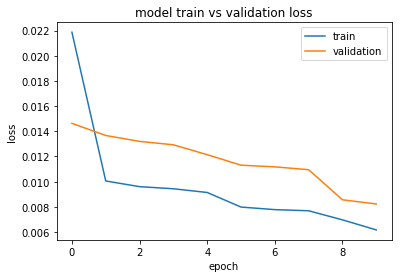

In [222]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [223]:
emb.save('embedding.h5')

In [227]:
X_ex = np.array([['Jeanne', 'aime', 'Marie'],
                 ['Jeanne', 'voit', 'Marie'],
                ['Pierre', 'tweetait', 'un', 'message'],
                ['Suzanne', 'googlera', 'la', 'réponse'],
                ['Anne',  'est', 'fatiguée']])
X_ex_ci = word_matrix_to_charint_matrix(X_ex, maxChars)
test_prediction = emb.predict(X_ex_ci)

In [228]:
print(test_prediction[0])

[  9.36150012e-17   7.52780349e-17   7.41816698e-17   2.09234317e-16
   1.85750933e-29   1.09733396e-16   8.79508786e-17   7.14386661e-17
   5.33385944e-17   4.92975888e-17   1.21776458e-24   1.89468304e-26
   6.81786944e-17   7.55101285e-17   7.22405152e-17   2.66180827e-19
   7.70056049e-17   4.58283934e-17   5.75198502e-17   1.03011469e-16
   2.37045479e-17   6.87574760e-17   4.80323235e-17   5.86648468e-17
   5.29703667e-17   7.20390437e-18   4.36727251e-18   6.19439893e-17
   4.25620755e-17   2.03291785e-16   8.89933776e-17   1.84835238e-25
   3.89063673e-17   2.09722463e-17   8.12122815e-17   1.02092544e-16
   2.61331652e-24   4.64293169e-17   6.75875051e-17   1.73399676e-25
   4.96014818e-17   1.28344662e-24   2.23509148e-17   1.63902236e-20
   5.13768498e-26   4.13087943e-17   1.05169093e-16   5.12546997e-26
   6.46315983e-17   6.91871334e-17   4.35938476e-17   3.82580596e-17
   9.59700108e-17   1.17076920e-16   8.31175233e-18   8.36379126e-17
   2.57283942e-17   6.75720401e-17

In [229]:
def display_pred(X_ex, test_prediction, minprob):
    word_counter = 0
    # iterate over sentences
    for i in range(len(X_ex)):
        # iterate over words
        for j in range(len(X_ex[i])):
            print(X_ex[i][j], end = ': ')
            # iterate over word features
            for k in range(len(test_prediction[word_counter])):
                if test_prediction[word_counter][k] > minprob:
                    print(integer_to_feature[k], end = ' ')
            print('')
            word_counter = word_counter + 1



In [233]:
categories = set(['v', 'n', 'nc', 'adj'])
tenses = set(['S', 'P', 'K', 'J', 'T', 'F', 'C', 'I', 'Y', 'G', 'W'])
person = set(['1', '2', '3'])
numer = set(['s', 'p'])
gender = set(['m', 'f'])

def best_inflection(feats, tenses, feature_to_integer, beta):

    maxp = 0
    maxinfl = None
    for t in tenses:
        tnum = feature_to_integer[t]
        prob = feats[tnum]
        if prob > maxp:
            maxp = prob
            maxinfl = t
    cutoff = maxp * beta
    result = {}
    for t in tenses:
        tnum = feature_to_integer[t]
        prob = feats[tnum]
        if prob > cutoff:
             result[t] = prob
    return maxinfl, result

In [231]:
display_pred(X_ex, test_prediction, 0.5)

Jeanne: nc 
aime: v pers nc Obj:sn 
Marie: np hum 
Jeanne: nc 
voit: v pers Obj:sn 
Marie: np hum 
Pierre: nc 
tweetait: v pers Obj:sn 
un: cf pro det nc pseudo-en 
message: nc 
Suzanne: nc 
googlera: v pers Obj:sn 
la: cla det nc 
réponse: v pers Obj:sn 
Anne: nc 
est: adj v pers nc 
fatiguée: Obl2:(par-sn) adj active v passive pers Obj:sn 


In [236]:
best_inflection(test_prediction[0][1], tenses, feature_to_integer, 0.1)

KeyError: 'I'